This notebook contains material reminding you of the process of correcting data taken by a CCD. Most of this material was covered back in Lab 4.

In [1]:
import numpy as np
from astropy.io import fits
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline
rc('figure', figsize=(12.0, 9.0)) # This line changes the default figure size to be 12x9

In [2]:
path = 'example_data/' #Filepath to the folder containing your data
biases = [] #initializes an empty list to put the bias data in
for i in range(1,11): #loop over the file indices corresponding to bias data
    biases.append(fits.getdata('Bias_'+ str(i) +'.fit', ext=0).astype(np.int))
    #The above line reads in the bias frames. This should look similar to past .fit loading,
    #where in this case the files have the naming format tBias000000XX.fit
    #The ext=0 argument tells Python which part of the fit file to load in (i.e., which extension of the file)
    #The final .astype(int) converts the loaded data to integers (by default, Python generally reads in data as strings)
    
avg_bias = np.asarray(biases).mean(axis=0) #Creates an average bias frame to subtract from all measurements    

In [3]:
#Similar code to the above, but for loading the lamp data, Sun data, and then backgrounds for each

lamp_on_He  = []
lamp_on_Ne  = []
lamp_off = []

sun_on  = []
sun_off = []

for i in range(1,4):
    sun_on.append(fits.getdata("Solar_" + str(i) +'.fit'.format(i), ext=0).astype(np.int))
    sun_off.append(fits.getdata("Ambient_" + str(i) +'.fit'.format(i), ext=0).astype(np.int))
    
for i in range(1,3):
    lamp_on_He.append(fits.getdata("He_" + str(i) +'.fit'.format(i), ext=0).astype(np.int))
    lamp_on_Ne.append(fits.getdata("Ne_" + str(i) +'.fit'.format(i), ext=0).astype(np.int))
    # First 2 elements in lamp_on are He and second 2 are Ne    
    lamp_off.append(fits.getdata("BG_" + str(i) +'.fit'.format(i), ext=0).astype(np.int))
    
    
    

In [4]:
#Then we correct our data by subtracting off the mean bias frame from each individual observation

#The format employed here is a simple form of Python's "List Comprehension"
#This is one of Python's more powerful features, which allows you to fill elements of a list
#in a fashion much like a for loop, but in a single line. Beyond compactness, Python can
#actually handle running this more efficiently than the same process in a proper for loop.

#Examine the syntax used in the list comprehension here to see how it compares to the more
#familiar syntax used in for loops. If the way this works is still unclear, you can ask your
#GSI for further explanation.
lamp_on_He_sub_bias = [lamp - avg_bias for lamp in lamp_on_He] 
lamp_on_Ne_sub_bias = [lamp - avg_bias for lamp in lamp_on_Ne] 
lamp_off_sub_bias = [lamp - avg_bias for lamp in lamp_off]
sun_on_sub_bias = [sun - avg_bias for sun in sun_on]
sun_off_sub_bias = [sun - avg_bias for sun in sun_off]

#Now we take the average bias-corrected background frame for the lamp and Sun
avg_lamp_off = np.asarray(lamp_off_sub_bias).mean(axis=0) #As we've used previously, np.asarray() turns a list into an array. Then, an array can be acted on by .mean(axis=0) to take the mean along the specified axis
avg_sun_off = np.asarray(sun_off_sub_bias).mean(axis=0)

In [5]:
#Next we subtract off the background from each of the lamp and Sun datasets, again using list comprehension
lamp_He_corrected = [lamp_on_He - avg_lamp_off for lamp_on_He in lamp_on_He_sub_bias]
lamp_Ne_corrected = [lamp_on_Ne - avg_lamp_off for lamp_on_Ne in lamp_on_Ne_sub_bias]
sun_corrected  = [sun_on - avg_sun_off for sun_on in sun_on_sub_bias]

#Finally, we use .mean() again to get the average lamp and sun observations
avg_lamp_He = np.asarray(lamp_He_corrected).mean(axis=0)
avg_lamp_Ne = np.asarray(lamp_Ne_corrected).mean(axis=0)
avg_sun = np.asarray(sun_corrected).mean(axis=0)

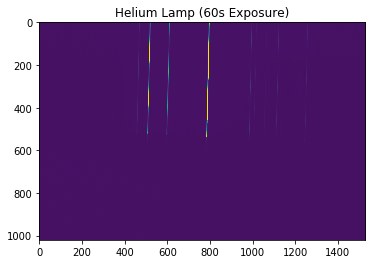

In [6]:
#plt.imshow() plots a 2x2 array of numbers into a plane where color represents the value of each array element
#The default colormap is called 'viridis,' where darker/bluer values are low, while brighter/yellower values are high
plt.imshow(avg_lamp_He) 
plt.title("Helium Lamp (60s Exposure)")
plt.show()

#This allows us to visualize where on the CCD the spectrum landed, based on where the bright lines appear
#This will then enable us to 'crop' the part of the array containing the spectrum and work only with that

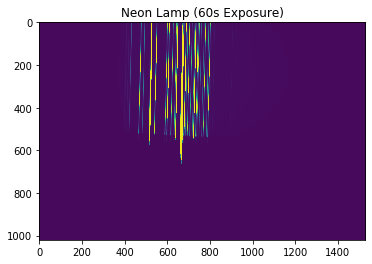

In [7]:
plt.imshow(avg_lamp_Ne) 
plt.title("Neon Lamp (60s Exposure)")
plt.show()

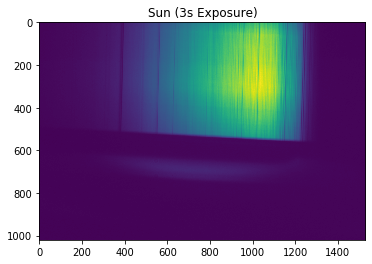

In [8]:
plt.imshow(avg_sun)
plt.title("Sun (3s Exposure)")
plt.show()

Text(0.5, 1.0, 'Sun')

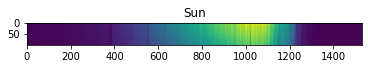

In [9]:
#Now we use array indexing to examine a chosen part of the spectrum to see if it contains the data we need (i.e., spectral lines).
plt.imshow(avg_sun[400:500,:])
plt.title("Sun")

Text(0.5, 1.0, 'Helium')

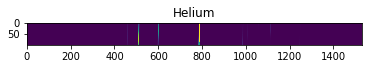

In [10]:
plt.imshow(avg_lamp_He[400:500,:])
plt.title("Helium")

Text(0.5, 1.0, 'Neon')

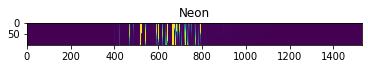

In [11]:
plt.imshow(avg_lamp_Ne[400:500,:])
plt.title("Neon")

/usr/local/anaconda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


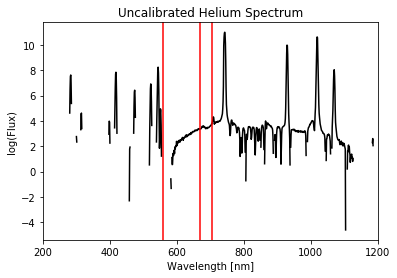

The red lines are the correct peak wavelengths, we need to adjust the data to fit this


In [12]:
lamp_good_He = np.asarray(avg_lamp_He[400:500,:]).mean(axis=0)#Averages the value along each column in the region that our spectra look relatively free of contamination
lamp_good_Ne = np.asarray(avg_lamp_Ne[400:500,:]).mean(axis=0)
sun_good  = np.asarray(avg_sun[400:500,:]).mean(axis=0)

example_lines_He = [558, 706, 668] #These are for example purposes, not actual wavelengths for the lamp

plt.plot(np.flip(np.arange(len(lamp_good_He)),0), np.log(lamp_good_He), 'k-') #np.flip(~~~) reverses the array inside it.
for line in example_lines_He:
    plt.axvline(line,color='r')
plt.xlabel('Wavelength [nm]')
plt.ylabel('log(Flux)')
plt.title("Uncalibrated Helium Spectrum")
plt.xlim(200,1200)
plt.show()

print("The red lines are the correct peak wavelengths, we need to adjust the data to fit this")

# The x-axis wavelength values are clearly incorrect. They need to be stretched and shifted so that the lines
# from the discharge tube match with their actual values. This correction can then also be applied to our solar spectra

/usr/local/anaconda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


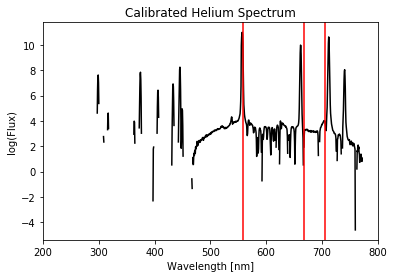

Stretch =  0.5612656614992568 nm/pixel
Shift =  140.17052452750048 nm


In [14]:
max_1 = 743 # nm
max_2 = 1020 # nm
max_3 = 930 # nm

correct_max_1 = 558 # nm
correct_max_2 = 706 # nm
correct_max_3 = 668 # nm

stretch1 =  (correct_max_2 - correct_max_1) / (max_2 - max_1)
stretch2 =  (correct_max_3 - correct_max_1) / (max_3 - max_1)
stretch = (stretch1 + stretch2) / 2

shift1 = correct_max_1 - (max_1*stretch)
shift2 = correct_max_2 - (max_2*stretch)
shift3 = correct_max_3 - (max_3*stretch)
shift = (shift1 + shift2 + shift3) / 3

plt.plot(np.flip(np.arange(len(lamp_good_He))*stretch + shift,0), np.log(lamp_good_He), 'k-') #np.flip(~~~) reverses the array inside it.
for line in example_lines_He:
    plt.axvline(line,color='r')
plt.xlabel('Wavelength [nm]')
plt.ylabel('log(Flux)')
plt.title("Calibrated Helium Spectrum")
plt.xlim(200,800)
plt.show()

print("Stretch = ", stretch, "nm/pixel")
print("Shift = ", shift, "nm")

/usr/local/anaconda/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


(200, 800)

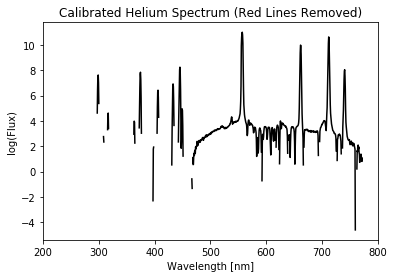

In [15]:
plt.plot(np.flip(np.arange(len(lamp_good_He))*stretch + shift,0), np.log(lamp_good_He), 'k-') #np.flip(~~~) reverses the array inside it.
plt.xlabel('Wavelength [nm]')
plt.ylabel('log(Flux)')
plt.title("Calibrated Helium Spectrum (Red Lines Removed)")
plt.xlim(200,800)

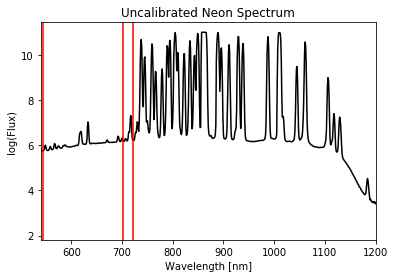

The red lines are the correct wavelengths, we need to adjust the data to fit this


In [16]:
plt.plot(np.flip(np.arange(len(lamp_good_Ne)),0), np.log(lamp_good_Ne), 'k-') #np.flip(~~~) reverses the array inside it.
example_lines_Ne = [545,702,722]
for line in example_lines_Ne:
    plt.axvline(line,color='r')
plt.xlabel('Wavelength [nm]')
plt.ylabel('log(Flux)')
plt.title("Uncalibrated Neon Spectrum")
plt.xlim(540,1200)
plt.show()

print("The red lines are the correct wavelengths, we need to adjust the data to fit this")

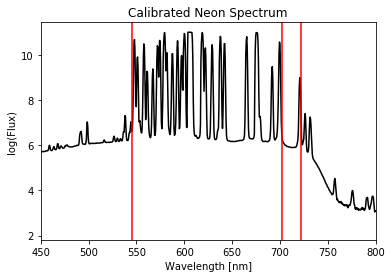

Stretch =  0.46956238080899326 nm/pixel
Shift =  201.32738632941889 nm


In [17]:
max_1 = 738 # nm
max_2 = 1062 # nm
max_3 = 1107 # nm

correct_max_1 = 545 # nm
correct_max_2 = 702 # nm
correct_max_3 = 722 # nm

stretch1 =  (correct_max_2 - correct_max_1) / (max_2 - max_1)
stretch2 =  (correct_max_3 - correct_max_1) / (max_3 - max_1)
stretch3 =  (correct_max_3 - correct_max_2) / (max_3 - max_2)
stretch = (stretch1 + stretch2 + stretch3) / 3

shift1 = correct_max_1 - (max_1*stretch)
shift2 = correct_max_2 - (max_2*stretch)
shift3 = correct_max_3 - (max_3*stretch)
shift = (shift1 + shift2 + shift3) / 3

plt.plot(np.flip(np.arange(len(lamp_good_Ne))*stretch + shift,0), np.log(lamp_good_Ne), 'k-') #np.flip(~~~) reverses the array inside it.
for line in example_lines_Ne:
    plt.axvline(line,color='r')
plt.xlabel('Wavelength [nm]')
plt.ylabel('log(Flux)')
plt.title("Calibrated Neon Spectrum")
plt.xlim(450,800)
plt.show()

print("Stretch = ", stretch, "nm/pixel")
print("Shift = ", shift, "nm")

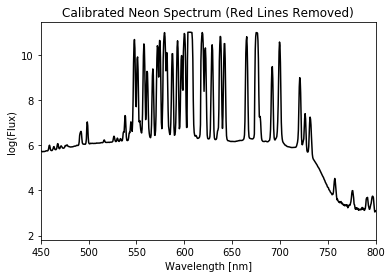

In [18]:
plt.plot(np.flip(np.arange(len(lamp_good_Ne))*stretch + shift,0), np.log(lamp_good_Ne), 'k-') #np.flip(~~~) reverses the array inside it.
plt.xlabel('Wavelength [nm]')
plt.ylabel('log(Flux)')
plt.title("Calibrated Neon Spectrum (Red Lines Removed)")
plt.xlim(450,800)
plt.show()

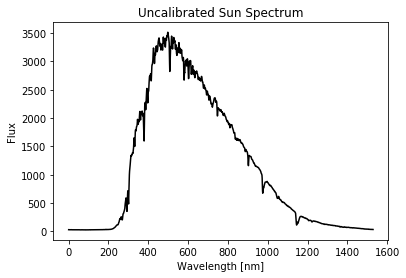

In [20]:
plt.plot(np.flip(np.arange(len(sun_good)),0), sun_good, 'k-') #np.flip(~~~) reverses the array inside it.
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux')
plt.title("Uncalibrated Sun Spectrum")
plt.show()

In [21]:
H = 270
K = 260
G = 290
F = 395
C = 900
D = 750
b = 510
this = []
this.append(H)
this.append(K)
this.append(G)
this.append(F)
this.append(C)
this.append(D)
this.append(b)

H_real = 397
K_real = 393
G_real = 431
F_real = 486
C_real = 656
D_real = 589
b_real = 517
real = []
real.append(H_real)
real.append(K_real)
real.append(G_real)
real.append(F_real)
real.append(C_real)
real.append(D_real)
real.append(b_real)

diff = 0
diff2 = 0
for i in range(0,7):
    for j in range(0,7):
        if(i < j):
            diff = diff + this[i] - this[j]
            diff2 = diff2 + real[i] - real[j]
stretch = diff2 / diff

shift_raw = 0
for i in range(0,7):
    shift_raw = shift_raw + real[i] - (this[i]*stretch)
shift = shift_raw / 7

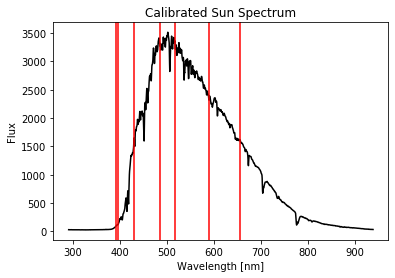

Stretch =  0.42294372294372296 nm/pix
Shift =  291.65213358070497 nm


In [22]:
plt.plot(np.flip(np.arange(len(sun_good))*stretch + shift,0), sun_good, 'k-') #np.flip(~~~) reverses the array inside it.
for line in real:
    plt.axvline(line,color='r')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux')
plt.title("Calibrated Sun Spectrum")
plt.show()
print("Stretch = ", stretch, "nm/pix")
print("Shift = ", shift, "nm")

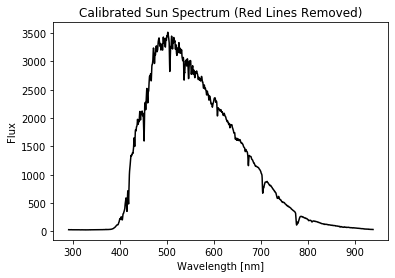

In [24]:
plt.plot(np.flip(np.arange(len(sun_good))*stretch + shift,0), sun_good, 'k-') #np.flip(~~~) reverses the array inside it.
plt.xlabel('Wavelength [nm]')
plt.ylabel('Flux')
plt.title("Calibrated Sun Spectrum (Red Lines Removed)")
plt.show()